In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import cmath
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
from nolitsa import delay
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.integrate import odeint
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.api import AutoReg, VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from iaaft import surrogates
from dynamical_systems_models import compute_EDMD, compute_VAR_p, construct_dictionary, perform_stability_analysis, get_stability_results, predict_EDMD, predict_VAR_p
from nld_utils import calculate_fnn_stat, get_nn_indices
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Systems

In [19]:
def vdp(x, t, mu):
    dx = np.zeros(2)
    dx[0] = x[1]
    dx[1] = mu*(1 - x[0]**2)*x[1] - x[0]
    return dx

def L96(x, t, N, dt=0.01):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d

def RK4(func, t0, y0, t_bound, dt=0.1, verbose=False):
    y_vals = np.zeros((int(t_bound/dt), len(y0)))
    t_vals = np.arange(y_vals.shape[0])*dt
    t = t0
    y = y0
    y_vals[0] = y
    for i, t in tqdm(enumerate(t_vals), disable=not verbose, total=len(t_vals)):
        k1 = func(t, y)
        k2 = func(t + dt/2, y + dt*k1/2)
        k3 = func(t + dt/2, y + dt*k2/2)
        k4 = func(t + dt, y + dt*k3)
        y += (1/6)*(k1 + 2*k2 + 2*k3 + k4)*dt
        y_vals[i] = y
    
    return y_vals, t_vals

# VDP Signal

In [121]:
signals = {}
signal_analysis = {}

total_time = 1000 # s
dt_sim = 0.001 # s
subsample_step = 1
T = int(total_time/dt_sim)
# mu_vals = [0.1, 0.2, 0.25, 0.3, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 4]
mu_vals = [0.001, 0.01, 0.1, 0.2, 0.5, 0.75, 1, 1.25, 2, 3, 4, 5]
# mu_vals = [0.001, 0.01]
# mu_vals = [5]
for mu in tqdm(mu_vals):
    x0 = np.random.randn()*2
    y0 = np.random.randn()*2
    
    # ------------
    # EULER
    # -----------
    time = np.arange(0.0, total_time, dt_sim)
    data = np.zeros((T, 2))
    data[0] = [x0, y0]
    for t in range(1, T):
        data[t] = data[t-1] + dt_sim*vdp(data[t-1], t*dt_sim, mu)
# #     # ------------
# #     # SCIPY
# #     # -----------
#     time = np.arange(0.0, total_time, dt_sim)
#     data = odeint(lambda x, t: vdp(x, t, mu=mu), [x0, y0], time)
    
    # ------------
    # RUNGE KUTTA
    # -----------
#     dynamic_noise_sd = 1
#     y, t = RK4(lambda t, v: np.array([v[1] + np.random.randn()*dynamic_noise_sd, mu*(1 - v[0]**2)*v[1] - v[0] + np.random.randn()*dynamic_noise_sd]), 0, (np.random.randn()*2, np.random.randn()*2), t_bound=total_time, dt=dt_sim, verbose=True)
#     data = y
    
    signals[f"mu = {mu}"] = data[np.arange(0, data.shape[0], subsample_step)]
        
signal_analysis = {}

  0%|          | 0/12 [00:00<?, ?it/s]

In [122]:
key = "mu = 5"
vdp_sig = signals[key]
signal = vdp_sig

In [123]:
num_lags = 200

# persistence baselines
# two time correlation matrix averages
C_mat_avgs = np.zeros(num_lags)
pb_mses = np.zeros(num_lags)
delayed_mi = np.zeros(num_lags)
for t in tqdm(range(num_lags)):
    C_mat = signal[:T - t].T @ signal[t:]
    C_mat_avgs[t] = C_mat.mean()
    
    pb_mse = ((signal[:T - t] - signal[t:])**2).mean()
    pb_mses[t] = pb_mse
    
    for i in range(signal.shape[1]):
        delayed_mi[t] += delay.mi(signal[:T-t, i], signal[t:, i], bins=64)
    delayed_mi[t] /= signal.shape[1]

  0%|          | 0/200 [00:00<?, ?it/s]

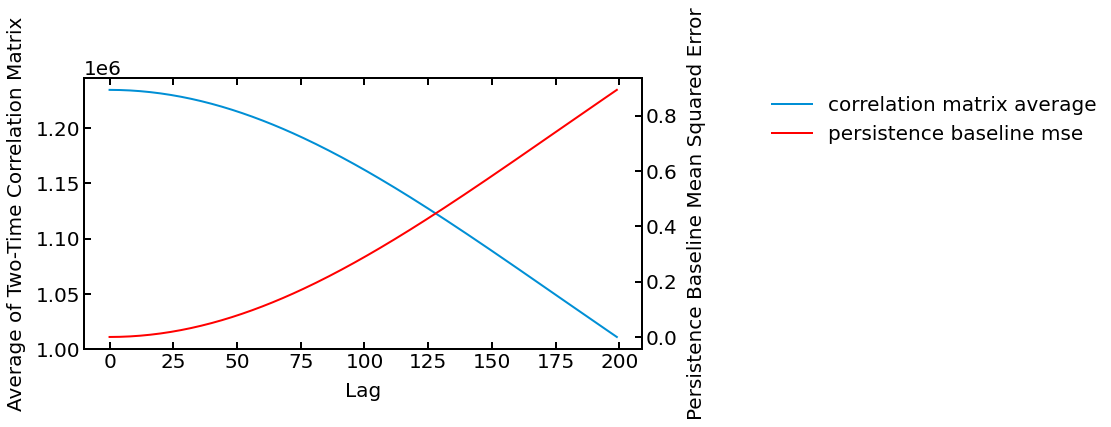

In [124]:
ln1 = plt.plot(C_mat_avgs, label='correlation matrix average')
ax = plt.gca()
ax.set_ylabel('Average of Two-Time Correlation Matrix')
local_min_inds = scipy.signal.argrelextrema(C_mat_avgs, np.less)[0]
if len(local_min_inds) > 0:
    ax.scatter(local_min_inds, C_mat_avgs[local_min_inds])
    ax.text(local_min_inds[0], C_mat_avgs[local_min_inds[0]]*0.86, f'Optimal Lag = {local_min_inds[0]}')
ax2 = ax.twinx()
ln2 = ax2.plot(pb_mses, c='red', label='persistence baseline mse')
ax2.set_ylabel('Persistence Baseline Mean Squared Error')
local_max_inds = scipy.signal.argrelextrema(pb_mses, np.greater)[0]
if len(local_max_inds) > 0:
    ax2.scatter(local_max_inds, pb_mses[local_max_inds], c='red')
    ax2.text(local_max_inds[0], pb_mses[local_max_inds[0]]*1.1, f'Optimal Lag = {local_max_inds[0]}')
ax.set_xlabel('Lag')
lns = ln1 + ln2
labs = [ln.get_label() for ln in lns]
plt.legend(lns, labs, bbox_to_anchor=(1.2, 1), loc='upper left')
plt.show()

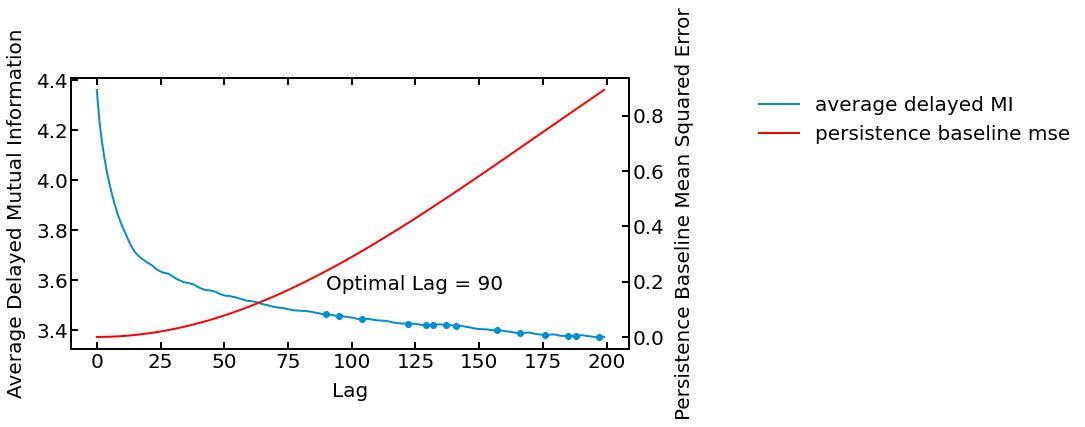

In [125]:
ln1 = plt.plot(delayed_mi, label='average delayed MI')
ax = plt.gca()
ax.set_ylabel('Average Delayed Mutual Information')
local_min_inds = scipy.signal.argrelextrema(delayed_mi, np.less)[0]
if len(local_min_inds) > 0:
    ax.scatter(local_min_inds, delayed_mi[local_min_inds])
    ax.text(local_min_inds[0], delayed_mi[local_min_inds[0]] + 0.1, f'Optimal Lag = {local_min_inds[0]}')
ax2 = ax.twinx()
ln2 = ax2.plot(pb_mses, c='red', label='persistence baseline mse')
ax2.set_ylabel('Persistence Baseline Mean Squared Error')
local_max_inds = scipy.signal.argrelextrema(pb_mses, np.greater)[0]
if len(local_max_inds) > 0:
    ax2.scatter(local_max_inds, pb_mses[local_max_inds], c='red')
    ax2.text(local_max_inds[0], pb_mses[local_max_inds[0]]*1.1, f'Optimal Lag = {local_max_inds[0]}')
ax.set_xlabel('Lag')
lns = ln1 + ln2
labs = [ln.get_label() for ln in lns]
plt.legend(lns, labs, bbox_to_anchor=(1.2, 1), loc='upper left')
plt.show()

In [126]:
# choosing tau
tau_choose = 'mi' # 'pb', corr', 'mi'
if tau_choose == 'pb':
    tau = scipy.signal.argrelextrema(pb_mses, np.greater)[0][0]
if tau_choose == 'corr':
    tau = scipy.signal.argrelextrema(C_mat_avgs, np.less)[0][0]
else: # tau_choose == 'mi'
    tau = scipy.signal.argrelextrema(delayed_mi, np.less)[0][0]

# Explicit Dictionary

In [148]:
# can either subsample the signal, or change the sampling of the delay embedding

# # NO SUBSAMPLING
# subsample_step = 1 
# tau_d = tau

# SUBSAMPLING
subsample_step = tau
tau_d = 1

signal_subsampled = signal[np.arange(0, signal.shape[0], subsample_step)]

dt_eff = dt_sim*subsample_step

signal_d = np.zeros((signal_subsampled.shape[0], 3))
signal_d[:, 0] = signal_subsampled[:, 0]
signal_d[:, 1] = signal_subsampled[:, 1]
signal_d[:, 2] = np.multiply(signal_subsampled[:, 0]**2, signal_subsampled[:, 1])

window = 3000
sig = signal_d[:window]
pred_sig = signal_d[window:]

In [149]:
sig.shape, pred_sig.shape

((3000, 3), (8112, 3))

In [150]:
p = 1
model = VAR(sig)
results = model.fit(p)

In [151]:
preds, true_vals, pb_mse = predict_VAR_p(pred_sig, results.coefs, results.intercept, persistence_baseline=True)

In [152]:
preds.shape

(8111, 3)

In [153]:
dt_eff

0.09

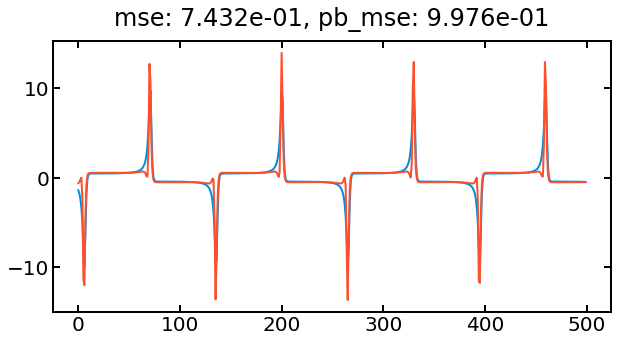

In [154]:
ind = 2
plt.plot(preds[-500:, ind])
plt.plot(true_vals[-500:, ind])
# plt.title(f"mse: {((preds[:, :2] - true_vals[:, :2])**2).mean():.3e}, pb_mse: {pb_mse:.3e}")
plt.title(f"mse: {((preds[:, ind] - true_vals[:, ind])**2).mean():.3e}, pb_mse: {pb_mse:.3e}")
plt.show()

In [155]:
(np.abs(np.linalg.eigvals(results.coefs)) - 1)/dt_eff

array([[-0.18046841, -2.09668571, -2.09668571]])

In [164]:
mat = np.eye(3)
for t in range(500):
    mat = results.coefs[0] @ mat

In [166]:
_, S, _ = np.linalg.svd(mat)
S

array([3.26457522e-04, 7.38897565e-21, 5.21296995e-21])

In [159]:
_, S, _ = np.linalg.svd(results.coefs[0])

In [162]:
np.log(S)/dt_eff

array([  5.89699444,   0.01872356, -10.74476789])

In [158]:
results.coefs

array([[[ 0.99604096,  0.10559609, -0.01836068],
        [-0.08758024,  1.28671914, -0.37807063],
        [-0.10480307,  1.0884822 ,  0.18139812]]])

In [140]:
np.log((np.abs(np.linalg.eigvals(results.coefs))))/dt_eff

array([[-0.18734626, -2.3410963 , -2.3410963 ]])

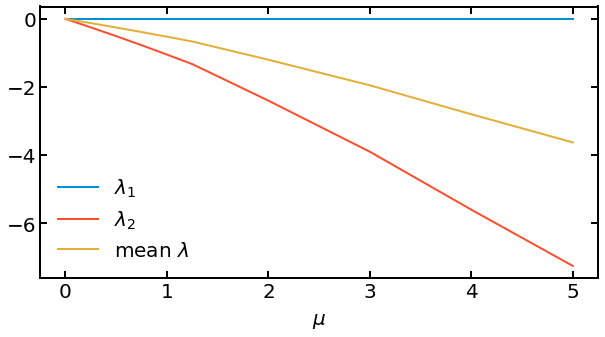

In [83]:
def lambda_2(mu):
    if mu < 2:
        return -mu  - (1/16)*(mu ** 3) + (263/18432)*(mu ** 5)
    elif mu >= 2 and mu <= 4:
        return (-1.2 + (mu - 2)*(-0.1))*mu
    elif mu > 4 and mu <= 5:
        return (-1.4 + (mu - 4)*(-0.05))*mu
#     elif mu == 2:
#         return -1.2*mu
#     elif mu == 3:
#         return -1.3*mu
#     elif mu == 4:
#         return -1.4*mu
#     elif mu == 5:
#         return -1.45*mu
    else:
        return None
# https://arxiv.org/pdf/2111.12198.pdf

plt.plot(mu_vals, np.zeros(len(mu_vals)), label=r'$\lambda_1$')
plt.plot(mu_vals, [lambda_2(mu_vals[i]) for i in range(len(mu_vals))], label=r'$\lambda_2$')
plt.plot(mu_vals, [(0 + lambda_2(mu_vals[i]))/2 for i in range(len(mu_vals))], label=r'mean $\lambda$')
# plt.plot(mu_vals, np.array(mean_top_10), label='mean top 10%')
# plt.plot(mu_vals, np.array(mean_bottom_10), label='mean bottom 10%')
# plt.plot(mu_vals, np.array(mean_vals), label='mean continuous exponent')
ax = plt.gca()
plt.xlabel(r'$\mu$')
plt.legend()
# ax2 = ax.twinx()
# ax2.plot(mu_vals, p_vals)

p = plt.show()